In [2]:
#!/usr/bin/env python
# coding: utf-8


from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.data import wine_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import model_selection
import json
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import random
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from multiprocessing import Pool
from collections import Counter

def class_fun(feature,profile,group):#
    exp_pre=profile.loc[feature,:]
    #test_exp_pre=test_profile.loc[feature,]
    dat2=exp_pre.stack()
    exp=dat2.unstack(0)
    #dat3=test_exp_pre.stack()
    #test_exp=dat3.unstack(0)
    rf_new = RandomForestClassifier(class_weight="balanced")
    rf_new.fit(exp, group)
    #prediction = rf_new.predict(test_exp)
    #交叉验证，5次准确率
    scores = cross_val_score(rf_new, exp, group, cv=5,scoring='accuracy')
    #print(scores)
    accuracy_value=pd.DataFrame({'accuracy':scores})
    mean_acc=accuracy_value.loc[:,'accuracy'].mean()
    #print(mean_acc)
    #accuracy_selection.append(accuracy_score(prediction, test_group))
    #cvs_selection.append(np.mean(scores))
    ##train_roc
    y_score = rf_new.predict_proba(exp)[:,1]
    fpr,tpr,threshold = metrics.roc_curve(group, y_score)
    roc_auc = metrics.auc(fpr,tpr)
    ##test_roc
    #y_score = rf_new.predict_proba(test_exp)[:,1]
    #fpr,tpr,threshold = metrics.roc_curve(test_group, y_score)
    #roc_auc_test = metrics.auc(fpr,tpr)

    #print(pred_y_rf_new)
    importance=rf_new.feature_importances_
    data = { 'gene' : feature, 'importance' :importance }
    df = pd.DataFrame(data)
    df.loc['ROC']=['ROC',roc_auc]
    #df.loc['ROC_test']=['ROC_test',roc_auc_test]
    df.loc['Mean_accuracy']=['Mean_accuracy',mean_acc]

    return df

def combination_fun(x,profile,group):
    #gene_all=[]
    all_value=pd.DataFrame({'gene_pair':[],'gene':[],'importance':[],'Rank':[],'roc':[],'module_two_genes':[],
                            'iteration1':[],'iteration2':[]})
    module=x.iloc[:,1].drop_duplicates().values.tolist()
    for mm in module:
        print(mm)
        gene_module=x.loc[x['modeuleType'] != mm].gene.tolist()
        #print(gene_module)
        y=x[x.modeuleType.isin([mm])].gene
        if len(y)<=1:
            gene=[y[0]]
            gene_all=gene_module+gene
            class_results=class_fun(gene_all,profile,group)#
            roc=class_results.loc['ROC'].importance
                #roc_test=class_results.loc['ROC_test'].importance
            mean_acc=class_results.loc['Mean_accuracy'].importance
            gene_importance=class_results.drop(index=["ROC","Mean_accuracy"])
            gene_importance['Rank'] = gene_importance['importance'].rank(method="average")

                #gene_all=gene_all.append(gene_importance)
                #roc_all.extend([roc])
            valuedf=pd.DataFrame({'gene_pair':'_'.join(gene),'gene':gene_importance.gene,'importance':gene_importance.importance,
                                      'Rank':gene_importance.Rank,
                                          'Mean_accuracy':mean_acc,
                                          'roc':roc,'module_two_genes':mm
                                          ,'iteration1':1,'iteration2':1})
            all_value=pd.concat([valuedf,all_value])
        else:
            for i in range(0,len(y)-1):
                for j in range(i+1,len(y)):
                    gene=[y[i],y[j]]
                    gene_all=gene_module+gene
                    #print(gene_all)
                    class_results=class_fun(gene_all,profile,group)#
                    roc=class_results.loc['ROC'].importance
                    #roc_test=class_results.loc['ROC_test'].importance
                    mean_acc=class_results.loc['Mean_accuracy'].importance
                    gene_importance=class_results.drop(index=["ROC","Mean_accuracy"])
                    gene_importance['Rank'] = gene_importance['importance'].rank(method="average")

                    #gene_all=gene_all.append(gene_importance)
                    #roc_all.extend([roc])
                    valuedf=pd.DataFrame({'gene_pair':'_'.join(gene),'gene':gene_importance.gene,'importance':gene_importance.importance,
                                      'Rank':gene_importance.Rank,
                                          'Mean_accuracy':mean_acc,
                                          'roc':roc,'module_two_genes':mm
                                          ,'iteration1':i,'iteration2':j})
                    all_value=pd.concat([valuedf,all_value])
                #print(gene)
    gene_all=findgene_fun(all_value,x)
    all_value.to_csv('all_value_com_train_notest.csv')
#print(gene_all)
    return gene_all



def jurge_fun(x):
    if x[6]==x[9]:
        y="a"
    else:
        y="b"
    return y

def findgene_fun(df1,df2):
    module_res=pd.merge(df1,df2,on='gene')
    module_res.loc[:,'type'] = module_res.apply(jurge_fun,1)
    module_res.loc[:,'id'] = module_res.index
    module_res1 =module_res.loc[module_res['type']=='a']
    rank_accuracy=module_res1.groupby(['modeuleType']).apply(lambda t: t[(t['Mean_accuracy']==t['Mean_accuracy'].max())])
    rank_accuracy1=rank_accuracy.drop(columns=['modeuleType'])
    rank_accuracy1.reset_index(inplace=True)
    rank_impor=rank_accuracy1.groupby(['modeuleType']).apply(lambda t: t[(t['Rank']==t['Rank'].max())])
    rank_impor1=rank_impor.drop(columns=['modeuleType','level_1'])
    rank_impor1.reset_index(inplace=True)
    #res_last=pd.merge(module_res,rank_impor1,on='id',how='right')
    #print(res_last['gene_x'])
    res_last=rank_impor1.loc[:,['gene_pair','modeuleType']]
    return res_last.drop_duplicates()


#read data
#dat=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/h3n2_train.csv',header=0,index_col=0))
dat=pd.DataFrame(pd.read_csv('dm_inter_train1113.csv',header=0,index_col=0))
#dat=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/deg_expression_limma.csv',header=0,index_col=0))
#h3n2_group=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/h3n2_group_all.csv',header=0,index_col=0))
gene=dat.index.tolist()
#dat1=dat.iloc[:,2:74]
dat2=dat.stack()

expression=dat2.unstack(0)
print(expression.shape)

####group
#group=[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]
#group=[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]
group=[ 1 ,0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]

print(len(group))


gene_module=pd.DataFrame(pd.read_csv('dm_inter_gene_module_train1113.csv'
                                      ,header=0,index_col=0))
print(gene_module.shape)
#last_iteration=circle_fun(500,gene_module,dat,group)#
arg_l = [(gene_module, dat, group) for i in range(1000)]

with Pool(72) as pool:
    res=pool.starmap(combination_fun, arg_l)
    pool.close()
    pool.join()

#def flat(a):
#    l=[]
#    for i in a:
#        if type(i) is list:
#            for j in i:
#                l.append(j)
#        else:
#            l.append(i)
#    return(l)
#gene_list = flat(res)
#print(gene_list)
#gene_count=Counter(gene_list)
#gene_count_all=pd.DataFrame.from_dict(gene_count,orient='index',columns=['count']).reset_index()

def flat(a):
    l=pd.DataFrame({'gene_pair':[],'modeuleType':[]})
    for i in a:
        l=pd.concat([l,i])
    return(l)

gene_list = flat(res)
print(gene_list)
type(gene_list)


tt=gene_list.groupby('modeuleType').value_counts()
#print(type(tt))
tt=tt.reset_index()
tt.columns = ['moduleType','gene_pair','count']
tt.to_csv('gene_count_train_notest1113.csv')



In [7]:
#read data
#dat=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/h3n2_train.csv',header=0,index_col=0))
dat=pd.DataFrame(pd.read_csv('/home/dulab/Documents/wrok/flu_paper/data/result_fi/dm_inter_train1113.csv',header=0,index_col=0))
#dat=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/deg_expression_limma.csv',header=0,index_col=0))
#h3n2_group=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/h3n2_group_all.csv',header=0,index_col=0))
gene=dat.index.tolist()
#dat1=dat.iloc[:,2:74]
dat2=dat.stack()

expression=dat2.unstack(0)
print(expression.shape)

####group
#group=[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]
#group=[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]
group=[ 1 ,0 ,0 ,0 ,1, 1, 1, 1, 0, 1, 0, 1 ,1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]

print(len(group))

dat1=pd.DataFrame(pd.read_csv('/home/dulab/Documents/wrok/flu_paper/data/result_fi/dm_inter_test1113.csv',header=0,index_col=0))
####group
y_test=[1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1]

(38, 119)
38


In [6]:
dat1.head

<bound method NDFrame.head of          GSM1513487  GSM1513491  GSM1513495  GSM1513499  GSM1513503  \
RPS4Y1     8.325116    7.768840   11.206015    7.643015    7.487843   
KDM5D      6.974310    6.797219    8.699331    6.740207    7.110488   
PRKY       6.234971    6.740194    7.949907    6.119341    6.149198   
DDX3Y      5.425697    5.169178    7.658501    6.046776    4.553224   
TCL1A      8.777076    8.603942    8.915351    9.894748    9.139836   
...             ...         ...         ...         ...         ...   
HMBS       9.063445    8.998222    8.842072    9.150825    9.305386   
GRINA      9.796184    9.728004   10.000750    9.269736    9.565606   
CRAT       8.813764    8.683454    8.631064    8.013767    8.070903   
RBM47     10.122007   10.511886   10.301821   10.116721   10.334591   
PIP5K1B    7.755360    7.297406    7.123007    7.115093    7.255899   

         GSM1513507  GSM1513511  GSM1513515  GSM1513519  GSM1513523  \
RPS4Y1    11.571155   11.206015    7.826609   

In [9]:
gene_count_all=pd.DataFrame(pd.read_csv('/home/dulab/Documents/wrok/flu_paper/data/result_fi/gene_count_train_notest1113.csv',header=0,index_col=0))
#gene_count_all=pd.DataFrame(pd.read_csv('/home/dulab/Documents/wrok/flu_paper/data/result_fi/gene_count_all_notest_balanced_noblack.csv',header=0,index_col=0))

gene_count_all.sort_values(by="count",ascending=False,inplace=True)

In [10]:
print(gene_count_all.groupby('moduleType').head(2))

        moduleType       gene_pair  count
37        MEGrey60          TXNDC5   1000
16          MECyan  ZWINT_SLC35E2A    318
17          MECyan   SLC35E2A_CD93    216
0           MEBlue    EZH2_RAP1GAP    178
39  MEMidnightblue      EIF1AY_MAK    144
38  MEMidnightblue    RPS4Y1_RBM47    144
27   MEGreenyellow      VPREB3_DSP     72
28   MEGreenyellow    VPREB3_MS4A1     72
1           MEBlue       AHSP_AMFR     72


In [11]:
gene_all=["TXNDC5","ZWINT","SLC35E2A","EZH2","RAP1GAP","EIF1AY","MAK","RPS4Y1","RBM47","VPREB3","DSP","MS4A1"]
          #"RBM47","PLAAT3","HLA-DOB","CD79B","WNK1","GYPB",]#['TXNDC5','DHRS9','CD93','OSBPL10','HLA-DOB','PRKY','PLAAT3','PDCD10','GYPB']#gene_count_all.sort_values(by="count",ascending=False)

In [12]:
test=class_fun(gene_all,dat,group,dat1,y_test)
print(test)

                        gene  importance
0                     TXNDC5    0.114564
1                      ZWINT    0.066280
2                   SLC35E2A    0.144976
3                       EZH2    0.116558
4                    RAP1GAP    0.092629
5                     EIF1AY    0.041661
6                        MAK    0.070619
7                     RPS4Y1    0.062653
8                      RBM47    0.088901
9                     VPREB3    0.085192
10                       DSP    0.070960
11                     MS4A1    0.045007
ROC                      ROC    1.000000
ROC_test            ROC_test    0.791667
Mean_accuracy  Mean_accuracy    0.653571


In [13]:
feature=gene_all#["ATP6V1D","HLA-DOB"]#
profile=dat
group=group
test_profile=dat1
test_group=y_test

In [ ]:
exp_pre=profile.loc[feature,:]
test_exp_pre=test_profile.loc[feature,]
dat2=exp_pre.stack()
exp=dat2.unstack(0)
dat3=test_exp_pre.stack()
test_exp=dat3.unstack(0)
rf_new = RandomForestClassifier(random_state=2345,class_weight="balanced")
rf_new.fit(exp, group)
    

RandomForestClassifier(class_weight='balanced_subsample', random_state=2345)

In [ ]:
parameters = {'n_estimators':list(range(25,200)),
              'criterion':['gini', 'entropy']#,
            #  'class_weight':['balanced_subsample','balanced']
         #     'max_depth': range(3, 18, 2),
            #      'oob_score':["True"],
        #'min_samples_split': range(1, 10, 1), 
        #'min_samples_leaf': range(1, 10, 1),
             #     'max_features': ['auto', 'sqrt', 'log2']
             } 
grid = GridSearchCV(RandomForestClassifier(n_jobs=-1,random_state=7895,class_weight="balanced"), parameters, cv=5)#scoring = 'average_precision',balanced,class_weight="balanced_subsample"
grid.fit(exp, group)
rf_new = grid.best_estimator_
rf_new=rf_new.fit(exp, group)

In [49]:
scoring = {'accuracy': make_scorer(accuracy_score),
               'roc_auc': make_scorer(roc_auc_score),
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score)}
rf_cv_score = model_selection.cross_validate(rf_new, exp, group, cv=5, scoring=scoring)
print(rf_cv_score)


{'fit_time': array([0.14706206, 0.12081075, 0.11053324, 0.0580256 , 0.0497427 ]), 'score_time': array([0.10210013, 0.13445997, 0.02282023, 0.01238799, 0.01279497]), 'test_accuracy': array([1.        , 0.5       , 1.        , 0.71428571, 0.71428571]), 'test_roc_auc': array([1.        , 0.53333333, 1.        , 0.70833333, 0.66666667]), 'test_precision': array([1.        , 0.66666667, 1.        , 0.75      , 0.66666667]), 'test_recall': array([1.  , 0.4 , 1.  , 0.75, 1.  ]), 'test_f1_score': array([1.  , 0.5 , 1.  , 0.75, 0.8 ])}


In [50]:
cv_score=pd.DataFrame(rf_cv_score)
cv_score.mean(axis=0)

fit_time          0.097235
score_time        0.056913
test_accuracy     0.785714
test_roc_auc      0.781667
test_precision    0.816667
test_recall       0.830000
test_f1_score     0.810000
dtype: float64

In [51]:
y_score = rf_new.predict_proba(test_exp)[:,1]
fpr,tpr,threshold = metrics.roc_curve(test_group, y_score)
roc_auc_test = metrics.auc(fpr,tpr)

In [52]:
print(y_score)
print(y_test)
print(tpr)
print(fpr)
print(roc_auc_test)

[0.79032258 0.82258065 0.61290323 0.62903226 0.59677419 0.32258065
 0.53225806 0.66129032 0.75806452 0.48387097 0.74193548]
[1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1]
[0.    0.125 0.625 0.625 1.    1.   ]
[0.         0.         0.         0.33333333 0.33333333 1.        ]
0.875


No handles with labels found to put in legend.


Feature ranking:
1. feature DSP (0.036320)
2. feature EIF1AY (0.050806)
3. feature MS4A1 (0.058230)
4. feature MAK (0.077630)
5. feature RBM47 (0.081316)
6. feature VPREB3 (0.084529)
7. feature RPS4Y1 (0.085738)
8. feature EZH2 (0.096754)
9. feature ZWINT (0.098858)
10. feature RAP1GAP (0.103406)
11. feature TXNDC5 (0.110707)
12. feature SLC35E2A (0.115705)


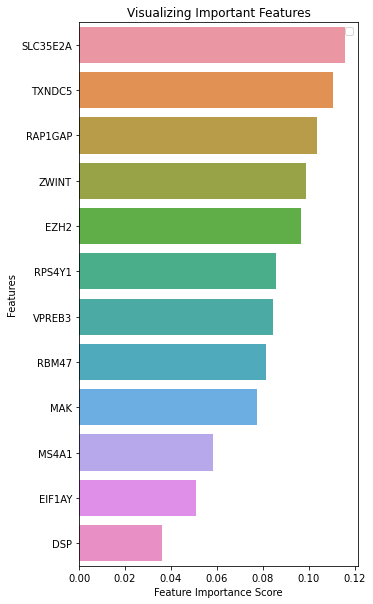

In [53]:
#print(pred_y_rf_new)
importance=rf_new.feature_importances_
#print(importance)
#print(gene)
indices = np.argsort(importance)
#print(indices)

# 输出排序
print("Feature ranking:")
featurerank=[]
im_value=[]
for f in range(exp.shape[1]):
    featurerank.append(gene_all[indices[f]])
    im_value.append(importance[indices[f]])
    print("%d. feature %s (%f)" % (f + 1, gene_all[indices[f]], importance[indices[f]]))
#特征重要性可视化
plt.figure(figsize=(5,10))
feature_imp = pd.Series(im_value,index=featurerank).sort_values(ascending=False)
sns.barplot(x= feature_imp,y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [55]:
data = { 'gene' : featurerank, 'importance' :im_value }
df = pd.DataFrame(data)
df.tail()
#df.iloc[305::]['gene']
df.to_csv('deg_module__inter_importance_train.csv')
df[df['importance']>0]

,gene,importance
0,DSP,0.036320
1,EIF1AY,0.050806
2,MS4A1,0.058230
3,MAK,0.077630
4,RBM47,0.081316
5,VPREB3,0.084529
6,RPS4Y1,0.085738
7,EZH2,0.096754
8,ZWINT,0.098858
9,RAP1GAP,0.103406
